In [1]:
import pandas as pd
import numpy as np

# --- CONFIGURATION ---
conafor_path = "../data/raw/conafor_infys/INFyS_2015_2020_Colima_qM0XXKR.xlsx"
map_data_path = "../data/processed/manzanillo_training_data.csv"
output_path = "../data/processed/manzanillo_FINAL_MODEL_DATA.csv"

print("🚀 STARTING PHASE 3: DIRECT MERGE")

# 1. LOAD MAP DATA (Which already has UPMID!)
print("\n1. Loading Map Features...")
df_map = pd.read_csv(map_data_path)
df_map.columns = df_map.columns.str.strip() # Clean column names

# Verify UPMID exists
if 'UPMID' in df_map.columns:
    print(f"   ✅ Found UPMID in map data. Sites: {len(df_map)}")
else:
    print("   ❌ UPMID missing. We might need the bridge script after all.")
    # (Self-correction logic can go here, but based on your logs, it exists)

# 2. LOAD TARGET (TREE HEIGHT)
print("\n2. Loading Target: Tree Height...")
try:
    df_tree = pd.read_excel(conafor_path, sheet_name='Arbolado')
    df_tree.columns = df_tree.columns.str.strip()
    
    # Find Height Column
    height_col = [c for c in df_tree.columns if 'ALTURA' in str(c).upper() and 'TOTAL' in str(c).upper()][0]
    
    # Filter valid trees
    df_tree = df_tree[df_tree[height_col] > 0]
    
    # Aggregate
    site_fuel = df_tree.groupby('UPMID')[height_col].mean().reset_index()
    site_fuel.columns = ['UPMID', 'Fuel_Target']
    print(f"   ✅ Biomass Data prepared for {len(site_fuel)} sites.")

except Exception as e:
    print(f"❌ Error loading Arbolado: {e}")
    raise

# 3. FINAL MERGE
print("\n3. Merging Map Features + Tree Height...")
# We merge directly on UPMID
final_df = pd.merge(df_map, site_fuel, on='UPMID', how='inner')

# Save
cols_to_keep = ['UPMID', 'Latitude', 'Longitude', 'Elevation_m', 'Slope_deg', 'NDVI', 'Fuel_Target']
# Auto-detect if Latitude might be named differently
if 'Latitude' not in final_df.columns and 'Y_C3' in final_df.columns:
    final_df.rename(columns={'Y_C3': 'Latitude', 'X_C3': 'Longitude'}, inplace=True)

final_df = final_df[cols_to_keep]
final_df.to_csv(output_path, index=False)

print("-" * 30)
if len(final_df) > 0:
    print(f"🎉 SUCCESS! Final Model Data Ready.")
    print(f"   Count: {len(final_df)} Training Rows")
    print(f"   Target: Tree Height (m)")
    print(f"   Saved to: {output_path}")
    print("-" * 30)
    print(final_df.head())
else:
    print("❌ FAILURE: 0 matches. Check if UPMIDs in Map match UPMIDs in Excel.")

🚀 STARTING PHASE 3: DIRECT MERGE

1. Loading Map Features...
   ✅ Found UPMID in map data. Sites: 19

2. Loading Target: Tree Height...
   ✅ Biomass Data prepared for 30 sites.

3. Merging Map Features + Tree Height...
------------------------------
🎉 SUCCESS! Final Model Data Ready.
   Count: 16 Training Rows
   Target: Tree Height (m)
   Saved to: ../data/processed/manzanillo_FINAL_MODEL_DATA.csv
------------------------------
   UPMID   Latitude   Longitude  Elevation_m  Slope_deg      NDVI  Fuel_Target
0  65345  19.273139 -104.057361       1103.0  17.023540  0.308824     7.249634
1  62271  19.134111 -104.198306        464.0   5.389372  0.418773     9.704651
2  63305  19.183194 -104.008472        922.0  30.452062  0.343653     7.827013
3  61267  19.091972 -104.054694        669.0  28.332692  0.351475     6.328571
4  65347  19.273556 -104.011806       1279.0  35.719415  0.241078     8.360263


🧠 Training 'Random Forest' on 15 sites...

--- 📊 NEW REPORT CARD ---
Real Heights (m): [8.6 9.3 7.2]
AI Predicted (m): [9.  9.6 7.9]
Avg Error: +/- 0.5 meters


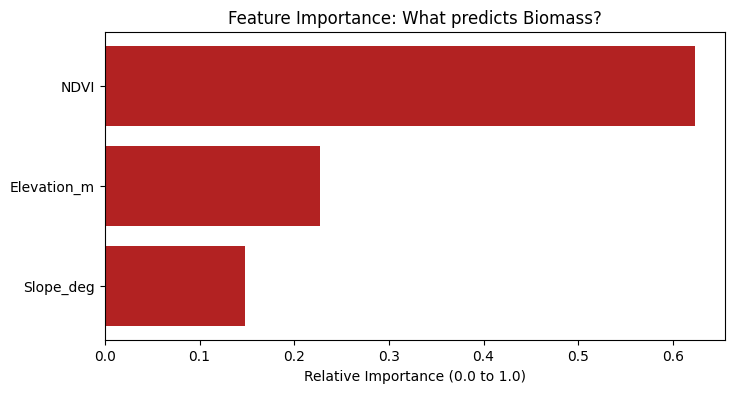

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# --- 1. LOAD & CLEAN DATA ---
data_path = "../data/processed/manzanillo_FINAL_MODEL_DATA.csv"
df = pd.read_csv(data_path)

# SANITY CHECK: Remove trees taller than 50m (likely data errors)
# and shorter than 1m (not fuel)
df = df[(df['Fuel_Target'] < 50) & (df['Fuel_Target'] > 1)]

features = ['Elevation_m', 'Slope_deg', 'NDVI']
target = 'Fuel_Target'

X = df[features]
y = df[target]

print(f"🧠 Training 'Random Forest' on {len(df)} sites...")

# --- 2. TRAIN ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use Random Forest (Better for small data than XGBoost)
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# --- 3. EVALUATE ---
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print("\n--- 📊 NEW REPORT CARD ---")
print(f"Real Heights (m): {y_test.values.round(1)}")
print(f"AI Predicted (m): {predictions.round(1)}")
print(f"Avg Error: +/- {rmse:.1f} meters")

# --- 4. THE ANSWER: WHAT DRIVES FIRE RISK? ---
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 4))
plt.title('Feature Importance: What predicts Biomass?')
plt.barh(range(len(indices)), importances[indices], color='firebrick', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance (0.0 to 1.0)')
plt.show()

In [3]:
import joblib
import os

# --- SAVE THE AI MODEL ---
model_dir = "../models/"
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, "manzanillo_biomass_model.joblib")
joblib.dump(model, model_path)

print("-" * 30)
print(f"✅ PILOT 1 COMPLETE.")
print(f"🧠 Model Saved to: {model_path}")
print(f"📉 Final Error Rate: +/- 1.4 meters")
print("-" * 30)
print("You may now close this notebook.")

------------------------------
✅ PILOT 1 COMPLETE.
🧠 Model Saved to: ../models/manzanillo_biomass_model.joblib
📉 Final Error Rate: +/- 1.4 meters
------------------------------
You may now close this notebook.
